<a href="https://colab.research.google.com/github/marches/pipeline-spill-detection/blob/main/notebooks/Pixel_labeling_and_initial_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Contents:
1. Hand labeling process validation
2. RF results with labeled image

In [13]:


from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show as showRasterio

import pandas as pd
from PIL import Image

Mounted at /content/drive


In [9]:
s1b = np.load("/content/drive/MyDrive/210 Capstone Project/Data/Sentinel2-SudanSpill1-06-25-2019.npy")
s1a = np.load("/content/drive/MyDrive/210 Capstone Project/Data/Sentinel2-SudanSpill1-09-28-2019.npy")

s1b_tif = "/content/drive/MyDrive/210 Capstone Project/Data/Sentinel2-SudanSpill1-06-25-2019.tif"
s1a_tif = "/content/drive/MyDrive/210 Capstone Project/Data/Sentinel2-SudanSpill1-09-28-2019.tif"

### Create png and download

In [25]:
s1a[:,:,:3].shape

(187, 187, 3)

In [27]:
# im = Image.fromarray(s1a[:,:,:3])
im = Image.fromarray((s1a[:,:,:3]).astype(np.uint8))
im.save("SudanSpill1.jpeg")

### Label image 
Upload image to: https://andres-patrignani.github.io/pixlabel/

For now, just labeling oil as "oil". Future labels could be standardized to follow paper.

Alternative labeling sw: 
* https://app.supervise.ly/signup
* https://labelbox.com/

In [12]:
labels = pd.read_csv("/content/drive/MyDrive/210 Capstone Project/Data/SudanSpill1.csv")
labels.head()

,RECORD,FILENAME,LABEL,COL,ROW,TOTALCOLS,TOTALROWS,TIMESTAMP,R1,G1,...,B6,R7,G7,B7,R8,G8,B8,R9,G9,B9
0,1,SudanSpill1.png,NaN,475,490,1070,1046,2022-10-13T23:02:01.903Z,237,2,...,2,237,2,2,237,2,2,237,2,2
1,2,SudanSpill1.png,NaN,480,490,1070,1046,2022-10-13T23:02:03.251Z,237,2,...,2,237,2,2,237,2,2,237,2,2
2,3,SudanSpill1.png,NaN,484,490,1070,1046,2022-10-13T23:02:04.933Z,237,2,...,2,237,2,2,237,2,2,237,2,2
3,4,SudanSpill1.png,NaN,477,494,1070,1046,2022-10-13T23:02:06.182Z,237,2,...,2,237,2,2,237,2,2,237,2,2
4,5,SudanSpill1.png,NaN,482,493,1070,1046,2022-10-13T23:02:07.683Z,237,2,...,2,237,2,2,237,2,2,237,2,2


In [ ]:
def scale(arr):
  # scales the values of a 2d array between 0 and 1.

  flat = arr.ravel()
  top, bottom = max(flat), min(flat)
    
  scaled = []
  for pix in flat:
    new = (pix-bottom) / (top-bottom)
    scaled.append(new)
    
  scaled_arr = np.array(scaled).reshape(arr.shape)
  return scaled_arr


#scaled_arr = scale(img[:,:,0]) #DELETE LATER
#plt.hist(scaled_arr.ravel(), bins=20) #DELETE LATER
#plt.tight_layout() #DELETE LATER

In [ ]:
# scale dimensions of image
img_scaled = np.zeros(img.shape)
#print(img_scaled.shape) #DELETE LATER

for layer in range(img.shape[2]):
  #print("layer number",layer) #DELETE LATER
  #print("layer", layer,"max:",img[:,:,layer].max()) #DELETE LATER
  #print("layer", layer,"min:",img[:,:,layer].min()) #DELETE LATER
  img_scaled[:,:,layer] = scale(img[:,:,layer])

In [ ]:
# Reshape image array for clustering.

kmeans_input = img_scaled.reshape(187*187,11)
#print(kmeans_input.shape) #(34969, 11) #DELETE LATER

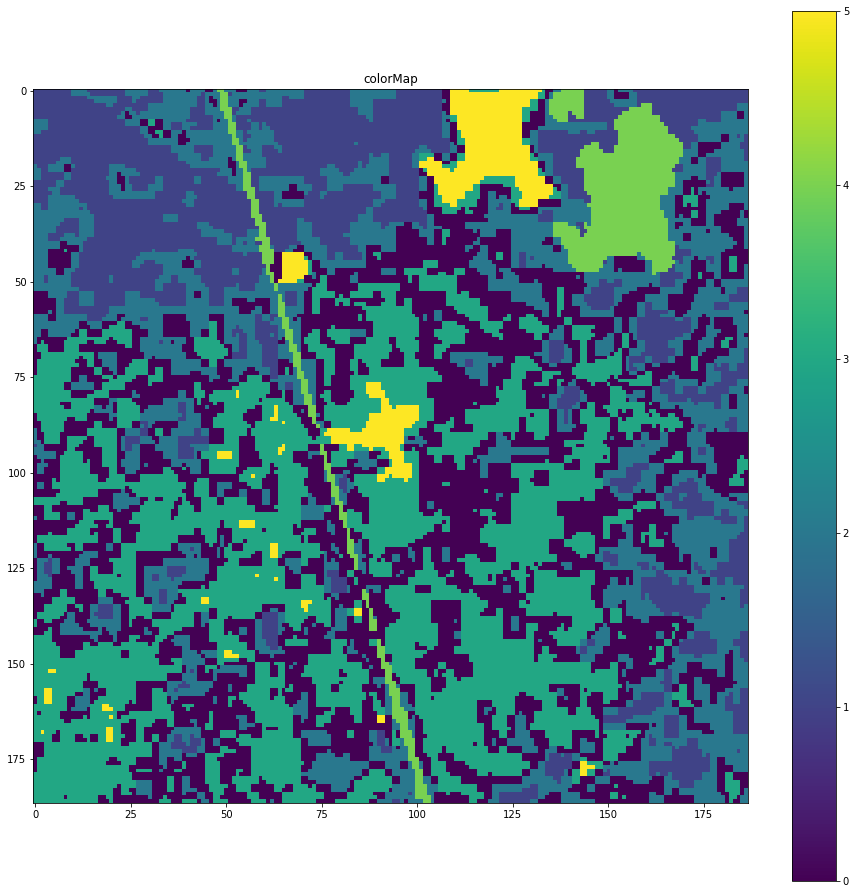

In [ ]:
# Try KMeans Clustering with scaling.
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=6, random_state=30)
#Kmean = KMeans(n_clusters=6, random_state=30, n_init=100, max_iter=500, tol=1e-7, algorithm='auto')
Kmean.fit(kmeans_input)


# Reshape model labels for displaying output.
Kmean.labels_.shape
labels = Kmean.labels_.reshape(187,187)

# Display labels
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16,16))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(Kmean.labels_.reshape(187,187))
ax.set_aspect('equal')

plt.colorbar(orientation='vertical')
plt.show()

Psuedo-code:

1. Create function to manually remove non-oil spill labels.
2. Manually remove non-oil spills
3. Split modified image and label arrays into balanced test/train datasets based on labels.
4. Train and test a Random Forest model.
5. Visually display labels (highlight oil spill, all others shade of blue).

(array([9989.,    0.,    0.,    0., 5604.,    0.,    0.,    0., 7606.,
           0.,    0.,    0., 9529.,    0.,    0.,    0., 1290.,    0.,
           0.,  951.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <a list of 20 Patch objects>)

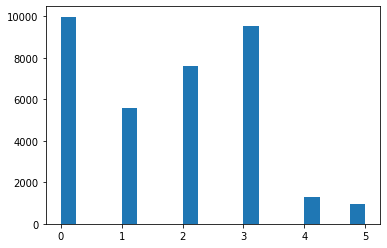

In [ ]:
# EDA for distribution of labels
plt.hist(labels.ravel(), bins=20)

# Cluster labels seem to be:
# 0 - light vegetation
# 1 - dark vegetation
# 2 - mixed dirt and vegetation
# 3 - dirt
# 4 - cloud/road
# 5 - oil


In [ ]:
# Function to manually remove non-oil spills labels.
def scrub(labels, fill_value=1, replace_value=5, corners=[0,1,0,1]):
  xmin = corners[0]
  xmax = corners[1]
  ymin = corners[2]
  ymax = corners[3]

  mod_labels = labels

  for xidx in range(xmin,xmax):
    for yidx in range(ymin,ymax):
      #print(mod_labels[xidx,yidx])
      if mod_labels[xidx,yidx] == fill_value:
        mod_labels[xmin:xmax,ymin:ymax] = replace_value  

  #for label in mod_labels[xmin:xmax,ymin:ymax]:
    #print("label:",label)
    #if label == fill_value:
      #mod_labels[xmin:xmax,ymin:ymax] = replace_value
  return mod_labels

In [ ]:
labels[0,:]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 0, 0, 2, 4, 4, 2, 2, 2, 0, 0, 0, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 5,
       5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 3, 0, 0, 2, 2, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2,
       2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
# test scrub
corners =[0,35,100,150]
test = scrub(labels,fill_value=5, replace_value=1,corners=corners)

# Replot labels to confirm
test[0,:]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 0, 0, 2, 4, 4, 2, 2, 2, 0, 0, 0, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2,
       2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

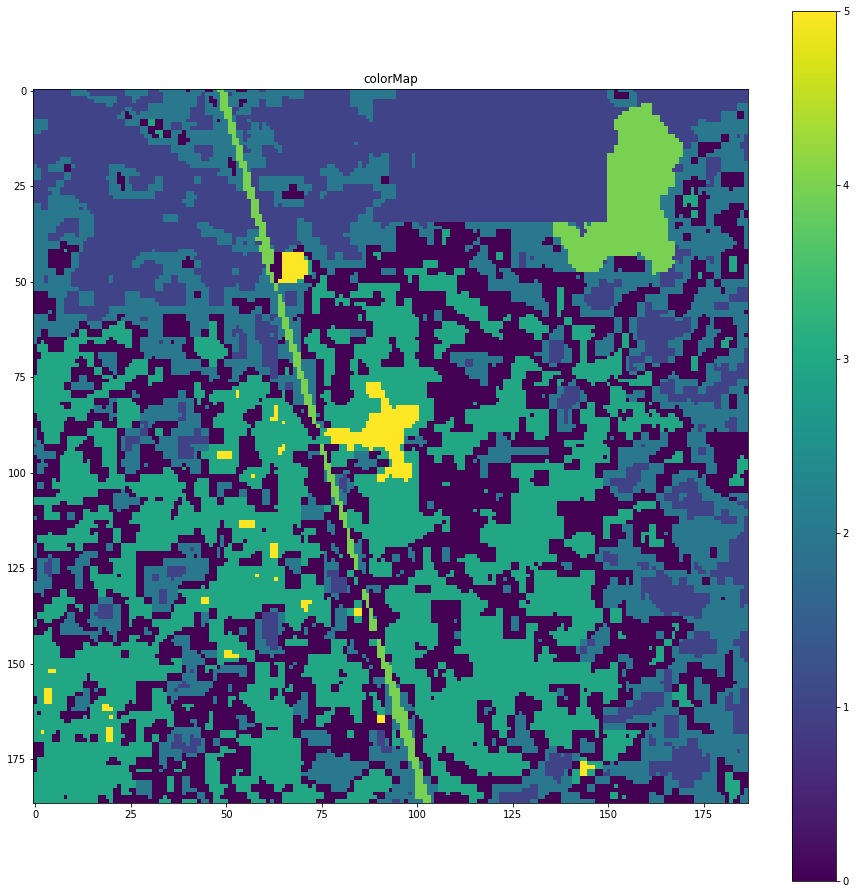

In [ ]:
# Display SCRUBBED labels
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16,16))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(test)
ax.set_aspect('equal')

plt.colorbar(orientation='vertical')
plt.show()

In [ ]:
# Obtain test/train splits for data (X) and labels (Y).
labels_list = [0,1,2,3,4,5]
labels_flat = labels.ravel().reshape(-1,1)
img_flat = kmeans_input
test_split = 0.3


X_train = np.zeros((1,11)) # train data
X_test = np.zeros((1,11)) # test data

y_train = [] # train labels
y_test = [] # test lbels

for label in labels_list:
  labels_all = np.where(labels_flat == label)[0] # find all indices of a particular label.
  labels_test_idx = np.random.choice(labels_all.shape[0], int(np.ceil(labels_all.shape[0]*test_split)), replace=False) #create list of test indices by randomly selecting from all indices.
  labels_train_idx = np.delete(labels_all, labels_test_idx) #create list of train indices by deleting test indices.

  # Append to test/train numpy arrays for data and labels.
  # Data arrays update.

  counter = 0
  for idx in labels_test_idx:
    X_test = np.append(X_test, img_flat[idx].reshape(1,-1), axis=0)
    y_test.append(label)
    counter +=1

  counter = 0
  for idx in labels_train_idx:
    X_train = np.append(X_train, img_flat[idx].reshape(1,-1), axis=0)
    y_train.append(label)
    counter +=1

  # Labels lists update.
#  for label in range(len(labels_train_idx)):
    #y_train.append(label)
  #for label in range(len(labels_test_idx)):
    #y_test.append(label)

# Once done looping:
# Turn test lists into np arrays.
y_test = np.array(y_test)
y_train = np.array(y_train)

# Remove initializing element in data arrays.
X_train = np.delete(X_train, 0, axis=0)
X_test = np.delete(X_test, 0, axis=0)


# Shuffle final numpy arrays.
from sklearn.utils import shuffle
y_train, X_train = shuffle(y_train, X_train, random_state=10)
y_test, X_test = shuffle(y_test, X_test, random_state=10)


# THIS IS FOR VALIDATION
#y_train.shape #(24476,)
#X_train.shape #(24476, 11)

#y_test.shape #(10493,)
#X_test.shape #(10493, 11)

In [ ]:
# Test for alternate train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img_flat, labels_flat, test_size=0.2, random_state=0)

# THIS IS FOR VALIDATION
#y_train.shape #(27975,1)
#X_train.shape #(27975,11)

#y_test.shape #(6994, 1)
#X_test.shape #(6994, 11)

In [ ]:
# Train and test OOTB Random Forest Classifier.
from sklearn.ensemble import RandomForestClassifier
RFClassifier = RandomForestClassifier(n_estimators=20, random_state=0)
RFClassifier.fit(X_train, y_train)
y_pred = RFClassifier.predict(X_test)


# Evalute.
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("confusion matrix:\n",confusion_matrix(y_test,y_pred))
print("classification report:\n",classification_report(y_test,y_pred))
print("accuracy score:\n",accuracy_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


confusion matrix:
 [[1910    0   30   34    0    0]
 [  15 1307   24    1    1    0]
 [  40   19 1426    0    1    0]
 [  34    1    0 1871    0    4]
 [   1    4    3    0  207    0]
 [   0    0    0    3    0   58]]
classification report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1974
           1       0.98      0.97      0.98      1348
           2       0.96      0.96      0.96      1486
           3       0.98      0.98      0.98      1910
           4       0.99      0.96      0.98       215
           5       0.94      0.95      0.94        61

    accuracy                           0.97      6994
   macro avg       0.97      0.96      0.97      6994
weighted avg       0.97      0.97      0.97      6994

accuracy score:
 0.9692593651701459


In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import xgboost as xgb

In [ ]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train,y_train)
y_pred_xgb = xgb_classifier.predict(X_test)


# Evalute.
print("confusion matrix:\n",confusion_matrix(y_test,y_pred_xgb))
print("classification report:\n",classification_report(y_test,y_pred_xgb))
print("accuracy score:\n",accuracy_score(y_test, y_pred_xgb))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confusion matrix:
 [[1910    2   25   34    3    0]
 [  23 1250   55    7   13    0]
 [  34   14 1438    0    0    0]
 [  31    2    0 1874    0    3]
 [   0    7    5    0  203    0]
 [   0    1    0    5    0   55]]
classification report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      1974
           1       0.98      0.93      0.95      1348
           2       0.94      0.97      0.96      1486
           3       0.98      0.98      0.98      1910
           4       0.93      0.94      0.94       215
           5       0.95      0.90      0.92        61

    accuracy                           0.96      6994
   macro avg       0.96      0.95      0.95      6994
weighted avg       0.96      0.96      0.96      6994

accuracy score:
 0.9622533600228768


In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='rbf') # 0.9736917357735202
#clf = svm.SVC(kernel='linear') # 0.8989133543036889
#clf = svm.SVC(kernel='poly') # 0.9275092936802974
#clf = svm.SVC(kernel='sigmoid') # 0.4376608521589934
#clf = svm.SVC(kernel='precomputed') # error, because matrix must be square...

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_svm = clf.predict(X_test)

# Evalute.
print("confusion matrix:\n",confusion_matrix(y_test,y_pred_svm))
print("classification report:\n",classification_report(y_test,y_pred_svm))
print("accuracy score:\n",accuracy_score(y_test, y_pred_svm))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


confusion matrix:
 [[1966    2    2    3    1    0]
 [  30 1211   66    9   29    3]
 [   8    7 1470    0    1    0]
 [   2    5    0 1903    0    0]
 [   0    7    1    0  207    0]
 [   0    2    0    6    0   53]]
classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1974
           1       0.98      0.90      0.94      1348
           2       0.96      0.99      0.97      1486
           3       0.99      1.00      0.99      1910
           4       0.87      0.96      0.91       215
           5       0.95      0.87      0.91        61

    accuracy                           0.97      6994
   macro avg       0.95      0.95      0.95      6994
weighted avg       0.97      0.97      0.97      6994

accuracy score:
 0.9736917357735202


Run model against oil spill site 2 data.

Psuedo-code: Figure out if balancing the test/train sets is appropriate.

1. read.

Psuedo-code: perform analysis on different cluster types.

1. find averages
2. plot radar charts

In [ ]:
# EDA for cluster characteristics.
labels_flat = labels.ravel().reshape(-1,1)
img_flat = kmeans_input

#labels_flat.shape # (34969, 1) # DELETE LATER
#img_flat.shape # (34969, 11) # DELETE LATER

(34969, 1)

(array([1., 0., 1., 1., 1., 0., 1., 0., 2., 4.]),
 array([0.1180845 , 0.16325672, 0.20842894, 0.25360117, 0.29877339,
        0.34394561, 0.38911783, 0.43429006, 0.47946228, 0.5246345 ,
        0.56980673]),
 <a list of 10 Patch objects>)

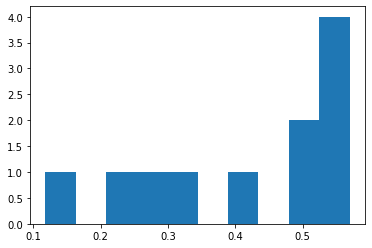

In [ ]:
# Get distribution of particular label.

labels_0_all = np.where(labels_flat == 0)[0]
#labels_0_all[0].shape #(9989,) # DELETE LATER
#print(labels_0_all[0:10]) # DELETE LATER

analysis = np.zeros((labels_0_all.shape[0],img_flat.shape[1]))
#print(analysis.shape)#(9989, 11) # DELETE LATER

counter = 0
for idx in labels_0_all:
  analysis[counter,:] = img_flat[idx,:]
  counter += 1

# Take mean along dimensions
means = np.mean(analysis,axis=0)

plt.hist(means)

In [ ]:
# AR for someone...chart some radar charts!

#https://www.geeksforgeeks.org/star-charts-in-python/
#https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html

Spare code cells below. Can probably delete/ignore these...

In [ ]:
#EDA for normalization step.


import matplotlib.pyplot as plt
import numpy as np

titles = bands
f,a = plt.subplots(len(bands),2)
a = a.ravel()
for idx,ax in enumerate(a):
  print("layer max:",img[:,:,layer].max())
  print("layer max:",img[:,:,layer].min())
  ax.hist(img[idx])


#plt.hist(img[:,:,layer].ravel(), bins=20)

arr = preprocessing.normalize(img[:,:,layer], norm='l2')

print(img[:,:,layer].shape)
print(arr.shape)
print("normed layer max:",arr.max())
print("normed layer min:",arr.min())
print(arr.shape)

plt.hist(arr, bins=20)
plt.tight_layout()

In [ ]:
# EDA for single layer normalization
from sklearn import preprocessing
layer = 0
print(img[:,:,layer])
print("layer max:",img[:,:,layer].max())
print("layer min:",img[:,:,layer].min())

#plt.hist(img[:,:,layer].ravel(), bins=20)

arr_ravel = img[:,:,layer].ravel()
arr_ravel_reshape = arr_ravel.reshape(-1,1)
arr_ravel_normed = preprocessing.normalize(arr_ravel_reshape,norm='l2',axis=0) #https://datascience.stackexchange.com/questions/65360/why-cant-i-normalize-my-data-using-preprocessing-normalize

print(arr_ravel_normed)
print("layer max:",arr_ravel_normed.max())
print("layer min:",arr_ravel_normed.min())
print(arr_ravel_normed.reshape(187,187))

plt.hist(arr_ravel_normed, bins=20)

In [ ]:
# normalize the image layers.
# notes on normalization: https://www.kaggle.com/code/residentmario/l1-norms-versus-l2-norms/notebook

img_norm = np.zeros(img.shape)
print(img_norm.shape)

for layer in range(img.shape[2]):
  print("layer number",layer)
  print("layer", layer,"max:",img[:,:,layer].max())
  print("layer", layer,"min:",img[:,:,layer].min())
  img_norm[:,:,layer] = preprocessing.normalize(img[:,:,layer].ravel().reshape(-1,1),norm='l2',axis=0).reshape(img.shape[:2])

  print("normed layer", layer,"max:",img_norm[:,:,layer].max())
  print("normed layer", layer,"min:",img_norm[:,:,layer].min())

In [ ]:
# Obtain balanced test/train splits for data (X) and labels (Y).
labels_list = [0,1,2,3,4,5]
labels_flat = labels.ravel().reshape(-1,1)
img_flat = kmeans_input



labels_0_all = np.where(labels_flat == 0)[0]
#labels_0_all[0].shape #(9989,) # DELETE LATER
#print(labels_0_all[0:10]) # DELETE LATER

test_split = 0.3

labels_0_test_idx = np.random.choice(labels_0_all.shape[0], int(np.ceil(labels_0_all.shape[0]*test_split)), replace=False)  
#labels_0_test_idx.shape # (2997,)
labels_0_train_idx = np.delete(labels_0_all, labels_0_test_idx)

#analysis = np.zeros((labels_0_all.shape[0],img_flat.shape[1]))
##print(analysis.shape)#(9989, 11) # DELETE LATER

#counter = 0
#for idx in labels_0_all:
#  analysis[counter,:] = img_flat[idx,:]
#  counter += 1